# Tensorflow and Keras model
## Imports and version check

In [8]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from IPython.display import Image

print(tf.__version__)
print(tf.test.is_built_with_cuda())

2.6.0
True


## Configuration

In [9]:
plt.style.use("ggplot")
np.set_printoptions(precision=3, suppress=True)
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

## Read CSV file

In [10]:
# current_path = os.path.dirname(os.path.realpath(__file__))
current_path = os.path.abspath('')
training_data_path = os.path.abspath(os.path.join(current_path, '..', '..', 'data', 'TRAINING_DATA_FIRST_1000.csv'))
csv_data = pd.read_csv(training_data_path)
csv_data.head()

,1,2,3,4,5,6,7,8,9,10,...,keff64,keff65,keff66,keff67,keff68,keff69,ppf_start,ppf_max,ppf_end,cycle_length_in_days
0,8,2,7,3,2,5,2,1,6,6,...,0.945909,0.944285,0.942662,0.941040,0.939418,0.937797,4.433,5.608,1.381,411.474034
1,6,4,4,9,9,9,1,3,6,7,...,0.952956,0.951327,0.949698,0.948070,0.946443,0.944816,2.690,2.690,1.320,432.732046
2,4,7,6,8,4,5,9,2,6,8,...,0.951664,0.950032,0.948401,0.946772,0.945143,0.943517,4.269,5.356,1.324,429.459459
3,4,7,2,6,1,5,1,6,4,4,...,0.947787,0.946196,0.944604,0.943012,0.941420,0.939828,5.760,7.038,1.422,409.351467
4,7,9,9,9,4,6,7,4,9,9,...,0.947005,0.945420,0.943835,0.942251,0.940666,0.939082,2.572,2.572,1.424,408.764331


## Split data into train and test

In [12]:
dataset = csv_data.copy()
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
1,800.0,5.028750,2.585300,1.000000,3.000000,5.000000,7.000000,9.000000
2,800.0,5.050000,2.585218,1.000000,3.000000,5.000000,7.000000,9.000000
3,800.0,5.150000,2.511550,1.000000,3.000000,5.000000,7.000000,9.000000
4,800.0,5.007500,2.557953,1.000000,3.000000,5.000000,7.000000,9.000000
5,800.0,5.060000,2.547943,1.000000,3.000000,5.000000,7.000000,9.000000
...,...,...,...,...,...,...,...,...
keff69,800.0,0.943369,0.007269,0.919120,0.938752,0.943520,0.948774,0.965607
ppf_start,800.0,3.242581,0.805702,2.166000,2.725750,3.025000,3.496750,8.818000
ppf_max,800.0,3.537511,1.266394,2.166000,2.726000,3.080500,3.907000,11.382000
ppf_end,800.0,1.363808,0.047415,1.257000,1.330000,1.361000,1.390000,1.565000


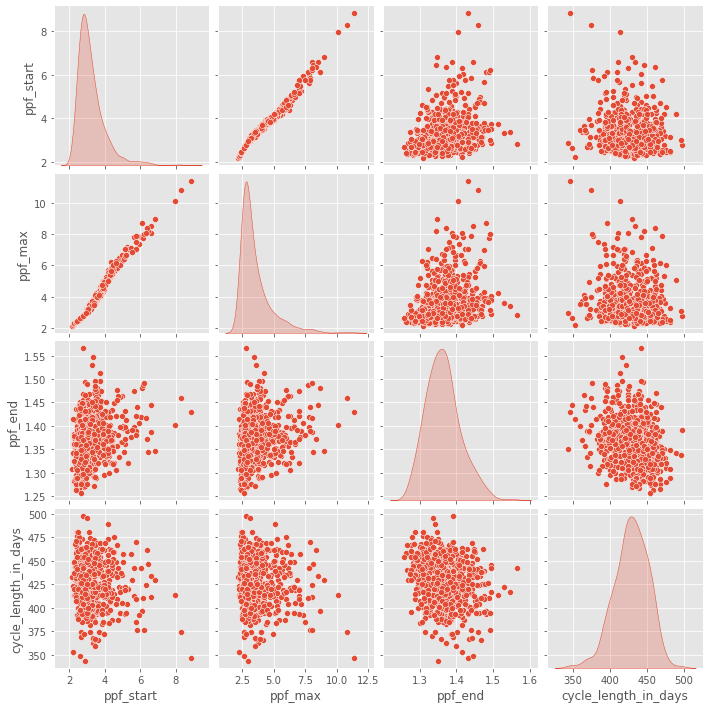

In [13]:
# sns.pairplot(train_dataset[['keff_start', 'keff_max', 'ppf_start', 'cycle_length_in_days']], diag_kind='kde')
sns.pairplot(train_dataset[['ppf_start', 'ppf_max', 'ppf_end', 'cycle_length_in_days']], diag_kind='kde')


## Split features from labels
Separate target values from the values on which the neural network is being trained.

In [14]:
vectors_train = train_dataset.iloc[:, :32].astype('uint8')
cycle_length_train = train_dataset.iloc[:, -1]
vectors_test = test_dataset.iloc[:, :32].astype('uint8')
cycle_length_test = test_dataset.iloc[:, -1]

# train_labels = train_dataset.pop("cycle_length_in_days")
# test_labels = test_dataset.pop("cycle_length_in_days")

## Normalization
Normalization layer normalizes values along rows.

In [15]:
normalizer = layers.Normalization(axis=1, mean=None)
normalizer.adapt(vectors_test)
first = vectors_train.iloc[:1]
print("First row: {} \nNormalized: {}"
      .format(first.to_numpy(), normalizer(first)))

First row: [[3 6 6 3 4 4 9 7 4 2 4 1 9 9 4 7 4 1 7 7 7 5 3 4 2 3 9 1 5 8 7 6]] 
Normalized: [[-0.748  0.446  0.385 -0.835 -0.343 -0.374  1.49   0.678 -0.495 -1.235
  -0.418 -1.669  1.708  1.459 -0.409  0.811 -0.43  -1.529  0.714  0.635
   0.778  0.024 -0.77  -0.466 -1.16  -0.756  1.454 -1.427  0.033  0.97
   0.681  0.432]]


# Model
## Layers

In [16]:
model = keras.Sequential([
    keras.Input(shape=(32,), dtype='uint8', name="input"),
    normalizer,
    layers.Dense(units=32, activation=keras.activations.relu),
    layers.Dense(units=16, activation=keras.activations.gelu),
    layers.Dense(units=8, activation=keras.activations.elu),
    layers.Dense(units=1, name="output")
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 32)                65        
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
output (Dense)               (None, 1)                 9         
Total params: 1,794
Trainable params: 1,729
Non-trainable params: 65
_________________________________________________________________


## Compile

In [17]:
model.compile(
    optimizer = keras.optimizers.Adam(learning_rate=0.1),
    loss = keras.losses.mean_absolute_error,
    metrics=[keras.metrics.mean_absolute_percentage_error]
)

## Fit

In [18]:
%%time
history = model.fit(
    vectors_train,
    cycle_length_train,
    epochs = 25,
    verbose = 0,
    validation_data = (vectors_test, cycle_length_test)
)

Wall time: 4.26 s


In [19]:
# history.history

#### Plot loss and other parameters from history

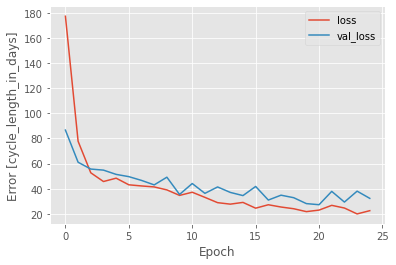

In [21]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    # plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error [cycle_length_in_days]')
    plt.legend()
    plt.grid(True)


plot_loss(history)

## Evaluation

In [22]:
results = model.evaluate(vectors_test, cycle_length_test)
print("test loss, test acc:", results)

7/7 [==============================] - 0s 4ms/step - loss: 32.3153 - mean_absolute_percentage_error: 7.5481
test loss, test acc: [32.315330505371094, 7.548056125640869]


In [23]:
x = vectors_test.iloc[:2]
print(cycle_length_test.iloc[:2])
y = model.predict(x)
print(y)

9     436.027726
11    427.790123
Name: cycle_length_in_days, dtype: float64
[[446.165]
 [480.018]]
